# Model Factory

In [1]:
import os, sys, math, datetime, csv
import psutil

# import pathlib
from pathlib import Path
import numpy as np
import random
from matplotlib import pyplot as plt
import PIL

import PIL.Image


In [2]:

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.layers import (
    Input,
    Dense,
    Add,
    Flatten,
    Conv2D,
    Dropout,
    Reshape,
    Activation,
    DepthwiseConv2D,
    MaxPooling2D,
    AvgPool2D,
    GlobalAveragePooling2D,
    Softmax,
    BatchNormalization,
    Concatenate,
    Permute,
    ReLU
)

from tensorflow.keras.models import Model
#from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#from dotenv import load_dotenv
from tf2cv.model_provider import get_model as tf2cv_get_model

# Import the necessary MLTK APIs
from mltk.core import view_model, summarize_model, profile_model

from workbench.config.config import initialize
from workbench.utils.utils import create_filepaths, get_file_size, create_model_name, append_dict_to_csv

import wandb
from wandb.keras import WandbCallback

# import deeplake

In [3]:
seed_1 = 1
seed_2 = 15
seed_3 = 30
seed_4 = 42
seed_5 = 75

seed = seed_1

# set the random seeds
os.environ["TF_CUDNN_DETERMINISTIC"]= "1"
# random.seed(seed)
# np.random.seed(seed)
# tf.random.set_seed(seed) # setting tensorflow global seed
tf.keras.utils.set_random_seed(seed)

In [4]:
models_dir = initialize()

In [5]:
tf.keras.backend.clear_session()

# Define the model

In [6]:

img_res = 96
channels = 3
classes = 3
alpha = 0.1
global dropout_rate
dropout_rate = 0.2
architecture = "shufflenet_v2tiny" #"mobilenet_v2_keras" ##"mobilenet_v3_large_keras" # "mobilenet_v3_small_keras" #"efficientNetB0_keras" #"mobilenet_v2_keras" #
loop_depth = 5
groups = 1 # [1, 2, 3, 4, 8] used in shuffleNetv1
first_layer_channels = 4 # standard 24
last_layer_channels = 1024 # standard 1024


In [7]:
input_shape = (img_res,img_res,channels)

In [8]:
model_stats = {"img_res" : img_res,
    "classes" : classes,
    "channels" : channels,
    "alpha" : alpha,
    "dropout_rate" : dropout_rate,
    }

In [9]:
def mobilenet_v1(input_shape, classes, alpha=1, loop_depth=5, global_average_pooling=True):
    """
    This function builds a CNN model according to the MobileNet V1 specification, using the functional API.
    The function returns the model.
    """
    global dropout_rate
    
    # MobileNet V1 Block
    def mobilenet_v1_block(x, filters, strides):
        # Depthwise convolution
        x = DepthwiseConv2D(kernel_size=3, strides=strides, padding="same")(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)  # TODO: option to change to ReLu6 or HardSwish

        # Pointwise convolution = standard convolution with kernel size =1
        x = Conv2D(filters=filters, kernel_size=1, strides=1)(x)  # strides for pointwise convolution must be 1
        x = BatchNormalization()(x)
        x = ReLU()(x)  # TODO: option to change to ReLu6 or HardSwish

        return x

    # Stem of the model
    inputs = Input(shape=input_shape)
    x = Conv2D(filters=32 * alpha, kernel_size=3, strides=2, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)  # TODO: option to change to ReLu6 or HardSwish

    # Main part of the model
    x = mobilenet_v1_block(x, filters=64 * alpha, strides=1)
    x = mobilenet_v1_block(x, filters=128 * alpha, strides=2)
    x = mobilenet_v1_block(x, filters=128 * alpha, strides=1)
    x = mobilenet_v1_block(x, filters=256 * alpha, strides=2)
    x = mobilenet_v1_block(x, filters=256 * alpha, strides=1)
    x = mobilenet_v1_block(x, filters=512 * alpha, strides=2)

    for _ in range(loop_depth):  # TODO: reduce the depth of the net for faster inference
        x = mobilenet_v1_block(x, filters=512 * alpha, strides=1)

    x = mobilenet_v1_block(x, filters=1024 * alpha, strides=2)
    x = mobilenet_v1_block(x, filters=1024 * alpha, strides=1)

    if global_average_pooling:  
        x = GlobalAveragePooling2D(keepdims=True)(x) #
        x = Dropout(dropout_rate)(x)
        x = Conv2D(filters=classes, kernel_size=1, strides=1, padding="same")(x)
        x = Reshape(target_shape=(classes,))(x)
        outputs = Activation("softmax")(x)

    else:
        # use the original implementation from the paper with average pooling and fully-connected layers
        x = AvgPool2D(pool_size=x.shape[-1], strides=1)(x)  # TODO: pool_size is dependent on the input resolution, lower resolutions than 224 might crash the architecture
        outputs = Dense(units=classes, activation="softmax")(x)  

    model = Model(inputs=inputs, outputs=outputs, name="mobilenetv1")

    return model

In [10]:
# Formular to avoid exccessive downsampling
# copied from: https://github.com/keras-team/keras/blob/v2.11.0/keras/applications/mobilenet_v2.py#L563

def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v



def mobilenet_v2(input_shape, classes, alpha=1, loop_depth=5, global_average_pooling=True):
    """
    This function builds a CNN model according to the MobileNet V2 specification, using the functional API.
    The function returns the model.
    """

    global block_id
    block_id = 1
    global dropout_rate

    # Expansion block
    def expansion_block(x, t, filters, block_id):
        prefix = f"block_{block_id}_"
        x = Conv2D(kernel_size=1, filters = filters * t, use_bias=False, name= prefix + "expand")(x)
        x = BatchNormalization(name = prefix + "expand_bn")(x)
        x = ReLU(6, name=prefix + "expand_relu")(x)
        return x

    def depthwise_block(x, strides, block_id):
        prefix = f"block_{block_id}_"
        x = DepthwiseConv2D(kernel_size=3, strides=strides, padding="same", use_bias=False, name= prefix + "dw_conv")(x)
        x = BatchNormalization(name = prefix + "dw_bn")(x)
        x = ReLU(6, name=prefix + "dw_relu")(x)
        return x

    def projection_block(x, out_channels, block_id):
        prefix = f"block_{block_id}_"
        x = Conv2D(filters=out_channels, kernel_size=1, strides=1, padding="same", use_bias=False, name= prefix + "compress")(x)
        x = BatchNormalization(name = prefix + "compress_bn")(x)
        return x

    def bottleneck_residual_block(x, t, filters, out_channels, strides):
        global block_id
        block_id =  block_id +1
        y = expansion_block(x, t, filters, block_id)
        y = depthwise_block(y, strides, block_id)
        y = projection_block(y, out_channels, block_id)

        # TODO: Check if this implementation is ok
        if y.shape[-1] == x.shape[-1]:
            y = Add()([x, y])
        return y

    # Avoid massive downsampling
    first_block_filters = _make_divisible(32 * alpha, 8)

    # Stem of the model
    inputs = Input(shape=input_shape)
    x = Conv2D(filters=first_block_filters, kernel_size=3, strides=2, padding="same", use_bias=False)(inputs)
    x = BatchNormalization(name='conv1_bn')(x)
    x = ReLU(6, name = 'conv1_relu')(x)  # TODO: option to change to ReLu6 or HardSwish


    # Main part of the model
    block_id = 0
    x = depthwise_block(x, strides=1, block_id=block_id)
    x = projection_block(x, out_channels=16 * alpha, block_id=block_id)

    # 2 identical layers
    x  = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=24 * alpha, strides=2) #, block_id=block_id +1)
    x  = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=24 * alpha, strides=1) #, block_id=block_id +1)

    # 3 repeated bottle_necks
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=32 * alpha, strides=2) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=32 * alpha, strides=1) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=32 * alpha, strides=1) #, block_id=block_id +1)   

    # 4 repeated bottle_necks
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=64 * alpha, strides=2) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=64 * alpha, strides=1) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=64 * alpha, strides=1) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=64 * alpha, strides=1) #, block_id=block_id +1)   

    # 3 repeated bottle_necks
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=96 * alpha, strides=1) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=96 * alpha, strides=1) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=96 * alpha, strides=1) #, block_id=block_id +1)   

    # 3 repeated bottle_necks
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=160 * alpha, strides=2) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=160 * alpha, strides=1) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=160 * alpha, strides=1) #, block_id=block_id +1)   

    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=320 * alpha, strides=1) #, block_id=block_id +1) 


    # no alpha applied to last conv as stated in the paper:
    # if the width multiplier is greater than 1 we increase the number of output
    # channels.
    if alpha > 1.0:
        last_block_filters = _make_divisible(1280 * alpha, 8)
    else:
        last_block_filters = 1280

    # 1*1 conv
    x = Conv2D(filters=last_block_filters, kernel_size=1, padding="same", use_bias=False, name="last_conv")(x)
    x = BatchNormalization(name='last_bn')(x)
    x = ReLU(6,name='last_relu')(x)


    if global_average_pooling:  
        x = GlobalAveragePooling2D(keepdims=True)(x)
        x = Dropout(dropout_rate)(x)
        x = Conv2D(filters=classes, kernel_size=1, strides=1, padding="same")(x)
        x = Reshape(target_shape=(classes,))(x)
        outputs = Activation("softmax")(x)
        #outputs = Softmax()(x)


    else:
        # use the original implementation from the paper with average pooling and fully-connected layers
        x = AvgPool2D(pool_size=7, strides=1)(x)  # TODO: pool_size is dependent on the input resolution, lower resolutions than 224 might crash the architecture
        outputs = Dense(units=classes, activation="softmax")(x)  # TODO: is there a stride=1 implementation in Dense?

    model = Model(inputs=inputs, outputs=outputs, name="mobilenetv2")

    return model

In [11]:
# # form https://github.com/keras-team/keras/blob/v2.11.0/keras/applications/mobilenet_v2.py#L96-L485
# def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id):
#     """Inverted ResNet block."""
#     channel_axis = 1 if backend.image_data_format() == "channels_first" else -1

#     in_channels = backend.int_shape(inputs)[channel_axis]
#     pointwise_conv_filters = int(filters * alpha)
#     # Ensure the number of filters on the last 1x1 convolution is divisible by
#     # 8.
#     pointwise_filters = _make_divisible(pointwise_conv_filters, 8)
#     x = inputs
#     prefix = f"block_{block_id}_"

#     if block_id:
#         # Expand with a pointwise 1x1 convolution.
#         x = layers.Conv2D(
#             expansion * in_channels,
#             kernel_size=1,
#             padding="same",
#             use_bias=False,
#             activation=None,
#             name=prefix + "expand",
#         )(x)
#         x = layers.BatchNormalization(
#             axis=channel_axis,
#             epsilon=1e-3,
#             momentum=0.999,
#             name=prefix + "expand_BN",
#         )(x)
#         x = layers.ReLU(6.0, name=prefix + "expand_relu")(x)
#     else:
#         prefix = "expanded_conv_"

#     # Depthwise 3x3 convolution.
#     if stride == 2:
#         x = layers.ZeroPadding2D(
#             padding=imagenet_utils.correct_pad(x, 3), name=prefix + "pad"
#         )(x)
#     x = layers.DepthwiseConv2D(
#         kernel_size=3,
#         strides=stride,
#         activation=None,
#         use_bias=False,
#         padding="same" if stride == 1 else "valid",
#         name=prefix + "depthwise",
#     )(x)
#     x = layers.BatchNormalization(
#         axis=channel_axis,
#         epsilon=1e-3,
#         momentum=0.999,
#         name=prefix + "depthwise_BN",
#     )(x)

#     x = layers.ReLU(6.0, name=prefix + "depthwise_relu")(x)

#     # Project with a pointwise 1x1 convolution.
#     x = layers.Conv2D(
#         pointwise_filters,
#         kernel_size=1,
#         padding="same",
#         use_bias=False,
#         activation=None,
#         name=prefix + "project",
#     )(x)
#     x = layers.BatchNormalization(
#         axis=channel_axis,
#         epsilon=1e-3,
#         momentum=0.999,
#         name=prefix + "project_BN",
#     )(x)

#     if in_channels == pointwise_filters and stride == 1:
#         return layers.Add(name=prefix + "add")([inputs, x])
#     return 

In [12]:
def mobilenet_v1_keras(input_shape, classes=classes, alpha=alpha):
    global dropout_rate
    model = tf.keras.applications.mobilenet.MobileNet(
        input_shape=input_shape,
        alpha=alpha,
        depth_multiplier=1,
        dropout=dropout_rate,
        include_top=True,
        weights=None, #'imagenet'
        input_tensor=None,
        pooling=None,
        classes=classes,
        classifier_activation='softmax',
        #**kwargs
    )

    #model._name = model.name + "_keras" # model.name cannot be overritten

    return model


In [13]:
def mobilenet_v2_keras(input_shape, classes=classes, alpha=alpha):
    model = tf.keras.applications.mobilenet_v2.MobileNetV2(
        input_shape=input_shape,
        alpha=alpha,
        include_top=True,
        weights=None, #'imagenet'
        input_tensor=None,
        pooling=None,
        classes=classes,
        classifier_activation='softmax',
        #**kwargs
    )

    #model._name = model.name + "_keras" # model.name cannot be overritten

    return model


In [14]:
def mobilenet_v3_small_keras(input_shape, classes=classes, alpha=alpha):
    global dropout_rate
    model = tf.keras.applications.MobileNetV3Small(
        input_shape=input_shape,
        minimalistic=False, # TODO find out about this parameter
        alpha=alpha,
        include_top=True,
        weights=None,
        input_tensor=None,
        classes=classes,
        classifier_activation="softmax",
        dropout_rate=dropout_rate,
        include_preprocessing=False
        #**kwargs
        )

    return model


In [15]:
def mobilenet_v3_large_keras(input_shape, classes=classes, alpha=alpha):
    global dropout_rate
    model = tf.keras.applications.MobileNetV3Large(
        input_shape=input_shape,
        minimalistic=False, # TODO find out about this parameter
        alpha=alpha,
        include_top=True,
        weights=None,
        input_tensor=None,
        classes=classes,
        classifier_activation="softmax",
        dropout_rate=dropout_rate,
        include_preprocessing=False
        #**kwargs
        )

    return model


In [16]:
def efficientNetB0_keras(input_shape, classes= classes, alpha= alpha):
    model = tf.keras.applications.efficientnet.EfficientNetB0(
        include_top=True,
        weights= None, #'imagenet',
        input_tensor=None,
        input_shape=input_shape,
        pooling=None,
        classes=classes,
        classifier_activation='softmax',
        #**kwargs
    )

    return model

In [17]:
def shufflenet_v1(input_shape, classes=classes, alpha= alpha, groups = 1):
    # inspired by https://github.com/Haikoitoh/paper-implementation/blob/main/ShuffleNet.ipynb

    #groups = 2 # [1, 2, 3, 4, 8]

    start_channels_dict={
        "1" : 144,
        "2" : 200,
        "3" : 240,
        "4" : 272,
        "8" : 384
    }

    start_channels = start_channels_dict[str(groups)]

    def channel_shuffle(x, groups):  
        batch, width, height, channels = x.get_shape().as_list()
        group_ch = channels // groups

        x = Reshape([width, height, group_ch, groups])(x)
        x = Permute([1, 2, 4, 3])(x)
        x = Reshape([width, height, channels])(x)
        return x

    def shuffle_unit(x, groups, channels, strides):

        y = x
        x = Conv2D(channels, kernel_size = 1, strides = (1,1),padding = 'same', groups=groups)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

        x = channel_shuffle(x, groups)
        
        x = DepthwiseConv2D(kernel_size = (3,3), strides = strides, padding = 'same')(x)
        x = BatchNormalization()(x)

        if strides == (2,2):
            channels = channels - y.shape[-1]
        x = Conv2D(channels, kernel_size = 1, strides = (1,1),padding = 'same', groups=groups)(x)
        x = BatchNormalization()(x)

        if strides ==(1,1):
            x =Add()([x,y])
        if strides == (2,2):
            y = AvgPool2D((3,3), strides = (2,2), padding = 'same')(y)
            x = Concatenate(axis=-1)([x,y]) # TODO: check if the axis is correct!
        
        x = ReLU()(x)
        return x

    # Main architecture

    input = Input (input_shape)

    x =  Conv2D (24,kernel_size=3,strides = (2,2), padding = 'same', use_bias = True)(input)
    x =  BatchNormalization()(x)
    x =  ReLU()(x)
    
    x = MaxPooling2D (pool_size=(3,3), strides = 2, padding='same')(x)

    repetitions = [3,7,3]

    for i,repetition in enumerate(repetitions):
        channels = start_channels * (2**i)

        x  = shuffle_unit(x, groups, channels * alpha ,strides = (2,2))

        for i in range(repetition):
            x = shuffle_unit(x, groups, channels * alpha ,strides=(1,1))

    x = GlobalAveragePooling2D()(x)

    output = Dense(classes,activation='softmax')(x)

    model = Model(input, output, name="shufflenetv1")
    return model

In [18]:
def shufflenet_v2(input_shape, classes=classes, alpha=alpha, use_bias=False):
    

    #groups = 2 # [1, 2, 3, 4, 8]

    start_channels_dict={  # based on alpha factor
        "0.5" : 48,
        "1" : 116,
        "1.5" : 176,
        "2" : 244,
    }

    first_layer_channels = 24
    last_layer_channels = 1024

    start_channels = start_channels_dict[str(alpha)]

    def channel_shuffle(x, groups):  
        batch, width, height, channels = x.get_shape().as_list()
        group_ch = channels // groups

        x = Reshape([width, height, group_ch, groups])(x)
        x = Permute([1, 2, 4, 3])(x)
        x = Reshape([width, height, channels])(x)
        return x

    def basic_unit(x, groups, channels):

        x,y = tf.split(x, num_or_size_splits=2, axis=-1) # channel split 
        x = Conv2D(channels, kernel_size = 1, strides = (1,1) ,padding = 'same', use_bias=use_bias)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        
        x = DepthwiseConv2D(kernel_size = (3,3), strides = (1,1), padding = 'same', use_bias=use_bias)(x)
        x = BatchNormalization()(x)

        x = Conv2D(channels, kernel_size = 1, strides = (1,1),padding = 'same', use_bias=use_bias)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

        x = Concatenate(axis=-1)([x,y]) # TODO: check if the axis is correct!
        x = channel_shuffle(x, 2)
        return x

    def down_sampling_unit(x, groups, channels):

        y = x
        x = Conv2D(channels, kernel_size = 1, strides = (1,1),padding = 'same', use_bias=use_bias)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        
        x = DepthwiseConv2D(kernel_size = (3,3), strides = (2,2), padding = 'same', use_bias=use_bias)(x)
        x = BatchNormalization()(x)

        x = Conv2D(channels, kernel_size = 1, strides = (1,1),padding = 'same', use_bias=use_bias)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

        y = DepthwiseConv2D(kernel_size = (3,3), strides = (2,2), padding = 'same', use_bias=use_bias)(y)
        y = BatchNormalization()(y)

        y = Conv2D(channels, kernel_size = 1, strides = (1,1),padding = 'same', use_bias=use_bias)(y)
        y = BatchNormalization()(y)
        y = ReLU()(y)

        x = Concatenate(axis=-1)([x,y]) # TODO: check if the axis is correct!
        x = channel_shuffle(x, 2)
        return x

    # Main architecture

    input = Input (input_shape)

    x =  Conv2D (first_layer_channels ,kernel_size=3, strides = (2,2), padding = 'valid', use_bias=use_bias)(input)
    x =  BatchNormalization()(x)
    x =  ReLU()(x)
    
    x = MaxPooling2D (pool_size=(3,3), strides = 2, padding='same')(x)

    repetitions = [3,7,3]

    channels = start_channels

    for i,repetition in enumerate(repetitions):

        x  = down_sampling_unit(x, groups, channels)

        for j in range(repetition):
            x = basic_unit(x, groups, channels)

        channels = channels * 2 # ShuffleNet V1 *(2**1)

    x =  Conv2D (last_layer_channels, kernel_size=1,strides = (1,1), padding = 'same', use_bias=use_bias)(x)
    x = GlobalAveragePooling2D()(x)

    output = Dense(classes,activation='softmax')(x)

    model = Model(input, output, name="shufflenetv2")
    return model

In [19]:
def shufflenet_v2tiny(input_shape, classes=classes, alpha=alpha, first_layer_channels=24, last_layer_channels=1024, use_bias=False):
    

    #groups = 2 # [1, 2, 3, 4, 8]

    start_channels_dict={  # based on alpha factor
        "0.05" : 6,
        "0.1" : 12,
        "0.2" : 24,
        "0.25" : 28,
        "0.3" : 34,        
        "0.5" : 48, # this is the smallest original architecture alpha
        "1" : 116,
        "1.5" : 176,
        "2" : 244,
    }

    # first_layer_channels = 24
    # last_layer_channels = 1024

    start_channels = start_channels_dict[str(alpha)]

    def channel_shuffle(x, groups):  
        batch, width, height, channels = x.get_shape().as_list()
        group_ch = channels // groups

        x = Reshape([width, height, group_ch, groups])(x)
        x = Permute([1, 2, 4, 3])(x)
        x = Reshape([width, height, channels])(x)
        return x

    def basic_unit(x, groups, channels):

        x,y = tf.split(x, num_or_size_splits=2, axis=-1) # channel split 
        x = Conv2D(channels, kernel_size = 1, strides = (1,1) ,padding = 'same', use_bias=use_bias)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        
        x = DepthwiseConv2D(kernel_size = (3,3), strides = (1,1), padding = 'same', use_bias=use_bias)(x)
        x = BatchNormalization()(x)

        x = Conv2D(channels, kernel_size = 1, strides = (1,1),padding = 'same', use_bias=use_bias)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

        x = Concatenate(axis=-1)([x,y]) # TODO: check if the axis is correct!
        x = channel_shuffle(x, 2)
        return x

    def down_sampling_unit(x, groups, channels):

        y = x
        x = Conv2D(channels, kernel_size = 1, strides = (1,1),padding = 'same', use_bias=use_bias)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        
        x = DepthwiseConv2D(kernel_size = (3,3), strides = (2,2), padding = 'same', use_bias=use_bias)(x)
        x = BatchNormalization()(x)

        x = Conv2D(channels, kernel_size = 1, strides = (1,1),padding = 'same', use_bias=use_bias)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

        y = DepthwiseConv2D(kernel_size = (3,3), strides = (2,2), padding = 'same', use_bias=use_bias)(y)
        y = BatchNormalization()(y)

        y = Conv2D(channels, kernel_size = 1, strides = (1,1),padding = 'same', use_bias=use_bias)(y)
        y = BatchNormalization()(y)
        y = ReLU()(y)

        x = Concatenate(axis=-1)([x,y]) # TODO: check if the axis is correct!
        x = channel_shuffle(x, 2)
        return x

    # Main architecture

    input = Input (input_shape)

    x =  Conv2D (first_layer_channels ,kernel_size=3, strides = (2,2), padding = 'valid', use_bias=use_bias)(input)
    x =  BatchNormalization()(x)
    x =  ReLU()(x)
    
    # exclude pooling layer to avoid model collapse
    #x = MaxPooling2D (pool_size=(3,3), strides = 2, padding='same')(x)

    repetitions = [3,7,3]

    channels = start_channels

    for i,repetition in enumerate(repetitions):

        x  = down_sampling_unit(x, groups, channels)

        for j in range(repetition):
            x = basic_unit(x, groups, channels)

        channels = channels * 2 # ShuffleNet V1 *(2**1)

    x =  Conv2D (last_layer_channels, kernel_size=1,strides = (1,1), padding = 'same', use_bias=use_bias)(x)
    x = GlobalAveragePooling2D()(x)

    output = Dense(classes,activation='softmax')(x)

    model = Model(input, output, name="shufflenetv2tiny")
    return model

In [20]:
#model = net = tf2cv_get_model("resnet18", pretrained=True, data_format="channels_last")
#model.build(input_shape)
#model.name

In [21]:

# model = shufflenet_v2(input_shape, classes=classes, alpha= alpha)
# model.name

In [22]:
#model = mobilenet_v1(input_shape, classes=classes, alpha=alpha)
#model = mobilenet_v2(input_shape, classes=classes, alpha=alpha)
#model = mobilenet_v1_keras(input_shape, classes=classes, alpha=alpha)
#model = mobilenet_v2_keras(input_shape, classes=classes, alpha=alpha)

In [23]:
def get_model(architecture, input_shape, classes, alpha, loop_depth= None,first_layer_channels=None, last_layer_channels=None, use_bias=False):
    global base_model_name
    if architecture=="mobilenet_v1":
        if loop_depth==None:
            model = mobilenet_v1(input_shape, classes=classes, alpha=alpha)
            variation_code ="000"
        else:
            model = mobilenet_v1(input_shape, classes=classes, alpha=alpha, loop_depth=loop_depth)
            variation_code ="l"+str(loop_depth)
        base_model_name = model.name
    elif architecture=="mobilenet_v1_keras":
        model = mobilenet_v1_keras(input_shape, classes=classes, alpha=alpha)
        variation_code ="keras"
        base_model_name = model.name.split("_")[0]+"v1"
    elif architecture=="mobilenet_v2":
        if loop_depth==None:
            model = mobilenet_v2(input_shape, classes=classes, alpha=alpha)
            variation_code ="000"
        else:
            model = mobilenet_v2(input_shape, classes=classes, alpha=alpha, loop_depth=loop_depth)
            variation_code ="l"+str(loop_depth)
        base_model_name = model.name
    elif architecture=="mobilenet_v2_keras":
        model = mobilenet_v2_keras(input_shape, classes=classes, alpha=alpha)
        variation_code ="keras"
        base_model_name = model.name.split("_")[0]#+"v2"
    elif architecture== "mobilenet_v3_small_keras":
        model = mobilenet_v3_small_keras(input_shape, classes=classes, alpha=alpha)
        variation_code ="keras"
        base_model_name = model.name.split("_")[0]
    elif architecture== "mobilenet_v3_large_keras":
        model = mobilenet_v3_large_keras(input_shape, classes=classes, alpha=alpha)
        variation_code ="keras"
        base_model_name = model.name.split("_")[0]
    elif architecture=="efficientNetB0_keras":
        model = efficientNetB0_keras(input_shape, classes=classes, alpha=alpha)
        variation_code ="keras"
        base_model_name = "efficientNetB0"
    elif architecture=="shufflenet_v1":
        model = shufflenet_v1(input_shape, classes=classes, alpha= alpha, groups=groups)
        variation_code ="g"+str(groups)
        base_model_name = model.name
    elif architecture=="shufflenet_v2":
        model = shufflenet_v2(input_shape, classes=classes, alpha= alpha)
        variation_code ="000"
        base_model_name = model.name

    elif architecture=="shufflenet_v2tiny":
        if (first_layer_channels==None) |(last_layer_channels==None) :
            model = shufflenet_v2tiny(input_shape, classes, alpha, first_layer_channels=24, last_layer_channels=1024, use_bias=False) 
            variation_code ="000"
        else:
            model = shufflenet_v2tiny(input_shape, classes, alpha, first_layer_channels=first_layer_channels, last_layer_channels=last_layer_channels, use_bias=False) 
            variation_code = "f"+str(first_layer_channels)+"l"+str(last_layer_channels)
        base_model_name = model.name
    else:
        #raise Exception e:
        print(f"Model architecture {architecture} is not supported.")

    return model, variation_code


In [24]:
model, variation_code = get_model(architecture, input_shape, classes, alpha, loop_depth, first_layer_channels=first_layer_channels, last_layer_channels=last_layer_channels)


In [25]:
base_model_name

'shufflenetv2tiny'

In [26]:
variation_code

'f8l1024'

In [27]:
# model = tf.keras.applications.efficientnet.EfficientNetB0(
#         include_top=True,
#         weights= None, #'imagenet',
#         input_tensor=None,
#         input_shape=input_shape,
#         pooling=None,
#         classes=classes,
#         classifier_activation='softmax',
#         #**kwargs
#     )

In [28]:
# model = efficientNetB0_keras(input_shape, classes=classes, alpha=alpha)

In [29]:
#model_name

In [30]:
model

In [31]:
# model = mobilenet_v1(input_shape, classes=classes, alpha=alpha, global_average_pooling=False)
# variation_code ="noGAP"

In [32]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [33]:
# Create the model name

model_name = create_model_name(base_model_name, alpha, input_shape, classes, variation_code)
print(model_name)

shufflenetv2tiny_0.05_96_c3_o3_f8l1024


In [34]:
model_stats["model_name"] = model_name

In [35]:
# Create the filepath structure
(
    models_path,
    models_summary_path,
    models_image_path,
    models_layer_df_path,
    models_tf_path,
    models_tflite_path,
    models_tflite_opt_path,
) = create_filepaths(model_name)

# mobilenet_v1 = keras.models.load_model(models_tf_path)

i:\tinyml\tiny_cnn\models
i:\tinyml\tiny_cnn\models\shufflenetv2tiny_0.05_96_c3_o3_f8l1024 does not exist.
Created path: i:\tinyml\tiny_cnn\models\shufflenetv2tiny_0.05_96_c3_o3_f8l1024.


In [36]:
# Show model in local version of Netron.app
view_model(model, tflite=True, build=True)

Serving 'C:/Users/Susanne/AppData/Local/Temp/Susanne/mltk/tmp_models/model.h5' at http://localhost:8080
Stopping http://localhost:8080


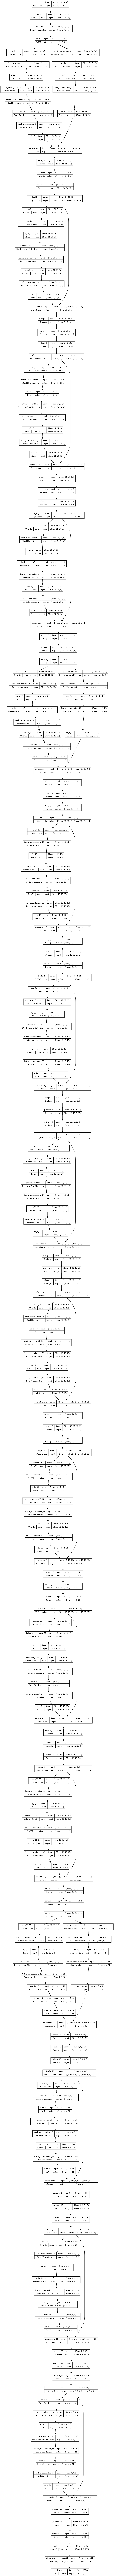

In [37]:
tf.keras.utils.plot_model(
    model,
    to_file=models_image_path,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",  # TB for vertical plot, LR for horizontal plot
    expand_nested=True,
    layer_range=None,
    dpi=200,
    show_layer_activations=True,
)

# Save the model summary


In [38]:
mltk_summary = summarize_model(model)
print(mltk_summary)


Model: "shufflenetv2tiny"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 47, 47, 8)    216         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 47, 47, 8)   32          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 47, 47, 8)    0           ['batch_normalizat

In [39]:
from contextlib import redirect_stdout

with open(models_summary_path, "w", encoding='utf-8') as f:
    with redirect_stdout(f):
        #model.summary()
        print(mltk_summary)

In [40]:
def parse_model_summary(filepath): 
    # Parse the MLTK model summary to grab important metrics   
    with open(filepath, "r") as f:
        lines = f.readlines() # list containing lines of file
        #columns = [] # To store column names

        i = 1
        for line in lines:
            line = line.strip() # remove leading/trailing white spaces
            if line.startswith("Total params:"):
                total_params = line.split()[-1]
                total_params = int(total_params.replace(",", ""))
            elif line.startswith("Trainable params:"):
                trainable_params = line.split()[-1]
                trainable_params =  int(trainable_params.replace(",", ""))
            elif line.startswith("Non-trainable params:"):
                non_trainable_params = line.split()[-1]
                non_trainable_params = int(non_trainable_params.replace(",", ""))
            elif line.startswith("Total MACs:"):
                MACs = line.split()[-2] + " " + line.split()[-1]
                #MACs = (float(MACs))
            elif line.startswith("Total OPs:"):
                FLOPs = line.split()[-2] + " " + line.split()[-1]
                #FLOPs = (float(FLOPs))
            else:
                pass
    
    return (total_params, trainable_params, non_trainable_params, MACs, FLOPs)


In [41]:
# MLTK profile model reads the mode from a path - only works for MLTK models! / Model must be trained first

#profiling_results = profile_model(model, accelerator='None', build=False)

In [42]:
total_params, trainable_params, non_trainable_params, MACs, FLOPs = parse_model_summary(models_summary_path)        

In [43]:
print(f"MACs: {MACs} - FLOPs {FLOPs}")


MACs: 3.537 M - FLOPs 7.281 M


In [44]:
model_stats["MACs"] = MACs
model_stats["FLOPs"] = FLOPs
model_stats["total_params"] = total_params
model_stats["trainable_params"] = trainable_params
model_stats["non_trainable_params"] = non_trainable_params

# Save the model

In [45]:
model.save(models_tf_path)
models_tf_path

WindowsPath('i:/tinyml/tiny_cnn/models/shufflenetv2tiny_0.05_96_c3_o3_f8l1024/shufflenetv2tiny_0.05_96_c3_o3_f8l1024.h5')

In [46]:
model_stats["model_size_kb"] = get_file_size(models_tf_path)

File size in bytes is 833920
File size in kilobytes is 814.375


In [47]:
#reconstructed_model = keras.models.load_model(models_tf_path)

# Let's check:
# np.testing.assert_allclose(
#     model.predict(test_input), reconstructed_model.predict(test_input)
# )

# # The reconstructed model is already compiled and has retained the optimizer
# # state, so training can resume:
# reconstructed_model.fit(test_input, test_target)


# Conversion to TFLite

In [48]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter = tf.lite.TFLiteConverter.from_saved_model(models_path)
tflite_model = converter.convert()


# Save the model.
with open(models_tflite_path, "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Susanne\AppData\Local\Temp\tmpwceivtix\assets


In [49]:
model_stats["tflite_model_size_kb"] = get_file_size(models_tflite_path)

File size in bytes is 319212
File size in kilobytes is 311.73046875


In [50]:
model_stats["time_stamp"] = datetime.datetime.now()

In [51]:
#csv_file_name = f"{base_model_name}_stats.csv"
csv_file_name = f"model_stats.csv"
csv_path = Path.cwd().joinpath(csv_file_name)
append_dict_to_csv(csv_path, model_stats)

In [52]:
# Login to W&B
wandb.login()

# Initialize a W&B run
run = wandb.init(project=f'{base_model_name}') #, group='alpha variations')

config = wandb.config
config.update(model_stats)
#wandb.log({'augmented data': augment_table})

# Finish the run
wandb.finish()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: susbrock. Use `wandb login --relogin` to force relogin


## Running inference on TFLite Interpreter

In [53]:
# # Initialize the TFLite interpreter
# interpreter = tf.lite.Interpreter(model_content=tflite_model)

# # Allocate the tensors
# interpreter.allocate_tensors()

In [54]:
# # Get input/output layer information
# i_details = interpreter.get_input_details()[0]
# o_details = interpreter.get_output_details()[0]

# # Get input quantization parameters.
# i_quant = i_details["quantization_parameters"]
# try:
#     i_scale      = i_quant['scales'][0]
# except:
#     i_scale = 1

# try:
#     i_zero_point = i_quant['zero_points'][0]
# except:
#     i_zero_point = 0

In [55]:
#i_details

# Conversion to TFLite with Quantization
A representative dataset is needed for quantization

## Create representative dataset for quantization

In [56]:
# data_dir = Path.cwd().parent.joinpath("lemon_dataset", "docs", "data")
# dataset_path = Path.cwd().joinpath("datasets", "lemon_dataset")
# dataset_path.exists()

# shuffle_seed = 42


# def get_lemon_quality_dataset(
#     dataset_path, img_width, img_height, batch_size, normalize=True
# ):
#     """Fetches the lemon quality dataset and prints dataset info. It normalizes the image data to range [0,1] by default.

#     Args:
#         dataset_path (Path): the file location of the dataset. Subfolders "train", "test", and "val" are expected.
#         normalize (boolean): Normalizes the image data to range [0, 1]. Default: True

#     Returns:
#         (train_ds, val_ds, test_ds, class_names) (tuple(tf.datasets)): Tensorflow datasets for train, validation and test.

#     """
#     if dataset_path.exists():
#         try:
#             train_dir = dataset_path.joinpath("train")
#             val_dir = dataset_path.joinpath("val")
#             test_dir = dataset_path.joinpath("test")
#         except:
#             print(f"Please check the folder structure of {dataset_path}.")
#             raise

#     print("Preparing training dataset...")
#     train_ds = tf.keras.utils.image_dataset_from_directory(
#         train_dir,
#         subset=None,
#         seed=shuffle_seed,
#         image_size=(img_height, img_width),
#         # batch_size=1)
#     )

#     class_names = train_ds.class_names

#     print("Preparing validation dataset...")
#     val_ds = tf.keras.utils.image_dataset_from_directory(
#         val_dir,
#         subset=None,
#         seed=shuffle_seed,
#         image_size=(img_height, img_width),
#         # batch_size=batch_size)
#     )

#     print("Preparing test dataset...")
#     test_ds = tf.keras.utils.image_dataset_from_directory(
#         test_dir,
#         subset=None,
#         seed=shuffle_seed,
#         image_size=(img_height, img_width),
#         # batch_size=batch_size)
#     )

#     # https://github.com/tensorflow/tensorflow/issues/56089

#     # # Normalize the data to the range [0, 1]
#     # if normalize:
#     #     normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)

#     #     train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
#     #     val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
#     #     test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
#     # else:
#     #     pass

#     print(f"Class names: {class_names}")
#     print(train_ds.element_spec)
#     #print(f"Normalize: {normalize}")
#     return (train_ds, val_ds, test_ds, class_names)

In [57]:
# IMG_WIDTH = input_shape[1]
# IMG_HEIGHT = input_shape[0]
# BATCH_SIZE = 32

# train_ds, val_ds, test_ds, labels = get_lemon_quality_dataset(
#     dataset_path, IMG_WIDTH, IMG_HEIGHT, BATCH_SIZE
# )

In [58]:
# rescale = tf.keras.layers.Rescaling(1.0 / 255, offset=-1)
# train_ds = train_ds.map(lambda x, y: (rescale(x), y))
# train_ds

In [59]:
# rep_ds = train_ds.unbatch()
# rep_ds

In [60]:
# def representative_data_gen():
#     # for input_value in train_ds.unbatch.batch(1).take(100):
#     for input_value, output_value in rep_ds.batch(1).take(100):
#         # Model has only one input so each data point has one element.
#         print(input_value)
#         yield [input_value]

## Convert model to INT8

In [61]:
# converter_INT = tf.lite.TFLiteConverter.from_keras_model(model)

# # Set the optimization flag.
# converter_INT.optimizations = [tf.lite.Optimize.DEFAULT]
# # Enforce integer only quantization
# converter_INT.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# converter_INT.inference_input_type = tf.int8
# converter_INT.inference_output_type = tf.int8
# # Provide a representative dataset to ensure we quantize correctly.
# # converter_INT.representative_dataset = representative_dataset(rep_ds)
# converter_INT.representative_dataset = representative_data_gen
# # converter_INT.representative_dataset = rep_ds
# model_tflite_opt = converter_INT.convert()

# # Save the model to disk
# with open(models_tflite_opt_path, "wb") as f:
#     f.write(model_tflite_opt)

In [62]:
# model_stats["tflite_INT8_model_size_kb"] = get_file_size(models_tflite_opt_path)

In [63]:
# # repr_ds = test_ds.unbatch()

# # def representative_data_gen():
# #   for i_value, o_value in repr_ds.batch(1).take(48):
# #     yield [i_value]
# converter_opt = tf.lite.TFLiteConverter.from_keras_model(model)
# #converter_opt = tf.lite.TFLiteConverter.from_saved_model(TF_MODEL)
# # converter.representative_dataset = tf.lite.RepresentativeDataset(representative_data_gen)
# converter_opt.optimizations = [tf.lite.Optimize.DEFAULT]
# #converter_opt.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# #converter_opt.inference_input_type = tf.int8

# tflite_model_opt = converter_opt.convert()

# # Save the model.
# with open(models_tflite_opt_path, 'wb') as f:
#   f.write(tflite_model_opt)


In [64]:
# str(models_tflite_opt_path)


### Convert the TFLite model to C-byte array with xxd

In [65]:
# #open("model.tflite", "wb").write(tfl_model)
# !apt-get update && apt-get -qq install xxd
# #!xxd -c 60 -i model.tflite > indoor_scene_recognition.h
# !xxd -c 60 -i i:\\tinyml\\tiny_cnn\\models\\mobilenet_0.25_96_c3\\mobilenet_0.25_96_c3_INT8.tflite' > model_INT.h


In [66]:
def get_flops(model) -> float:
    """
    Calculate FLOPS [GFLOPs] for a tf.keras.Model or tf.keras.Sequential model
    in inference mode. It uses tf.compat.v1.profiler under the hood.
    """
    # if not hasattr(model.model, "model"):
    #     raise wandb.Error("self.model must be set before using this method.")

    if not isinstance(
        model, (tf.keras.models.Sequential, tf.keras.models.Model)
    ):
        raise ValueError(
            "Calculating FLOPS is only supported for "
            "`tf.keras.Model` and `tf.keras.Sequential` instances."
        )

    from tensorflow.python.framework.convert_to_constants import (
        convert_variables_to_constants_v2_as_graph,
    )

    # Compute FLOPs for one sample
    batch_size = 1
    inputs = [
        tf.TensorSpec([batch_size] + inp.shape[1:], inp.dtype)
        for inp in model.inputs
    ]

    # convert tf.keras model into frozen graph to count FLOPs about operations used at inference
    real_model = tf.function(model).get_concrete_function(inputs)
    frozen_func, _ = convert_variables_to_constants_v2_as_graph(real_model)

    # Calculate FLOPs with tf.profiler
    run_meta = tf.compat.v1.RunMetadata()
    opts = (
        tf.compat.v1.profiler.ProfileOptionBuilder(
            tf.compat.v1.profiler.ProfileOptionBuilder().float_operation()
        )
        .with_empty_output()
        .build()
    )

    flops = tf.compat.v1.profiler.profile(
        graph=frozen_func.graph, run_meta=run_meta, cmd="scope", options=opts
    )

    # convert to GFLOPs
    return (flops.total_float_ops / 1e9) / 2

In [67]:
#get_flops(model)

In [68]:
# import re
# import hexdump
# import tensorflow as tf


# def port(model, optimize=False, variable_name='model_data', pretty_print=False):
#     converter = tf.lite.TFLiteConverter.from_keras_model(model)
#     if optimize:
#         if isinstance(optimize, bool):
#             optimizers = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
#         else:
#             optimizers = optimize
#         converter.optimizations = optimizers
#     tflite_model = converter.convert()
#     bytes = hexdump.dump(tflite_model).split(' ')
#     c_array = ', '.join(['0x%02x' % int(byte, 16) for byte in bytes])
#     c = 'const unsigned char %s[] DATA_ALIGN_ATTRIBUTE = {%s};' % (variable_name, c_array)
#     if pretty_print:
#         c = c.replace('{', '{\n\t').replace('}', '\n}')
#         c = re.sub(r'(0x..?, ){12}', lambda x: '%s\n\t' % x.group(0), c)
#     c += '\nconst int %s_len = %d;' % (variable_name, len(bytes))
#     preamble = '''
# // if having troubles with min/max, uncomment the following
# // #undef min    
# // #undef max
# #ifdef __has_attribute
# #define HAVE_ATTRIBUTE(x) __has_attribute(x)
# #else
# #define HAVE_ATTRIBUTE(x) 0
# #endif
# #if HAVE_ATTRIBUTE(aligned) || (defined(__GNUC__) && !defined(__clang__))
# #define DATA_ALIGN_ATTRIBUTE __attribute__((aligned(4)))
# #else
# #define DATA_ALIGN_ATTRIBUTE
# #endif
# '''
#     return preamble + c

In [69]:
#tflite_model = converter.convert()

In [70]:
#variable_name='model_data'

In [71]:
# def c_code_generator(tflite_model,variable_name="model_data", pretty_print=False):
#     """Creating c_code from TensorFlow Lite model. 
#        Code inspired by: https://github.com/eloquentarduino/tinymlgen/blob/master/tinymlgen/tinymlgen.py

#     Args:
#         tflite_model (_type_): _description_
#         variable_name (str, optional): _description_. Defaults to "model_data".
#         pretty_print (bool, optional): _description_. Defaults to False.

#     Returns:
#         _type_: _description_
#     """
#     bytes = hexdump.dump(tflite_model).split(' ')
#     c_array = ', '.join(['0x%02x' % int(byte, 16) for byte in bytes])
#     c = 'const unsigned char %s[] DATA_ALIGN_ATTRIBUTE = {%s};' % (variable_name, c_array)
#     if pretty_print:
#         c = c.replace('{', '{\n\t').replace('}', '\n}')
#         c = re.sub(r'(0x..?, ){12}', lambda x: '%s\n\t' % x.group(0), c)
#     c += '\nconst int %s_len = %d;' % (variable_name, len(bytes))
#     preamble = '''
#     // if having troubles with min/max, uncomment the following
#     // #undef min    
#     // #undef max
#     #ifdef __has_attribute
#     #define HAVE_ATTRIBUTE(x) __has_attribute(x)
#     #else
#     #define HAVE_ATTRIBUTE(x) 0
#     #endif
#     #if HAVE_ATTRIBUTE(aligned) || (defined(__GNUC__) && !defined(__clang__))
#     #define DATA_ALIGN_ATTRIBUTE __attribute__((aligned(4)))
#     #else
#     #define DATA_ALIGN_ATTRIBUTE
#     #endif
#     '''
#     c_code = preamble + c
#     return c_code

In [72]:
#c_code = c_code_generator(tflite_model)

In [73]:
#c_code